# Predict Generosity of Customers

In this activity, I will practice using tree-based modeling techniques to predict on a binary target class.<br>
**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
**The goal** of this model is to predict whether or not a customer is a generous tipper.

## Questions to Consider

1. **What are you being asked to do?**<br>
Predict if a customer will **not** leave a tip.<br>

2. **What are the ethical implications of the model? What are the consequences of your model making errors? What is the likely effect of the model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't)? What is the likely effect of the model when it predicts a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?**<br>
Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happened often, drivers might not trust the app.
Drivers are unlikely to pick up people who are predicted to not leave tips. Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company. Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.

3. **Do the benefits of such a model outweigh the potential problems?**
It's not good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh the benefits.

4. **Would you proceed with the request to build this model? Why or why not?**
No. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk.

5. **Can the objective be modified to make it less problematic?**
We can build a model that predicts the most generous customers. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.

Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous&mdash;those who will tip 20% or more? Consider the following questions:


1. **What features do you need to make this prediction?**
Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.

2. **What would be the target variable?**
The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

3. **What metrics will you use to evaluate the model?**
This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

### Imports and data loading

In [58]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [59]:
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares in nyc_preds_means.csv file.

In [60]:
# Load dataset into dataframe
df0 = pd.read_csv('data//2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous analysis
nyc_preds_means = pd.read_csv('data//nyc_preds_means.csv')

In [61]:
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [62]:
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


## Explore and prepare the data
### Join the two dataframes

In [63]:
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


In [64]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

I know from my EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, I'll need to sample the data to select only the customers who pay with credit card. 

In [65]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0[df0['payment_type']==1].copy()

In [66]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15265 non-null  int64  
 1   VendorID               15265 non-null  int64  
 2   tpep_pickup_datetime   15265 non-null  object 
 3   tpep_dropoff_datetime  15265 non-null  object 
 4   passenger_count        15265 non-null  int64  
 5   trip_distance          15265 non-null  float64
 6   RatecodeID             15265 non-null  int64  
 7   store_and_fwd_flag     15265 non-null  object 
 8   PULocationID           15265 non-null  int64  
 9   DOLocationID           15265 non-null  int64  
 10  payment_type           15265 non-null  int64  
 11  fare_amount            15265 non-null  float64
 12  extra                  15265 non-null  float64
 13  mta_tax                15265 non-null  float64
 14  tip_amount             15265 non-null  float64
 15  tolls_a

## Feature engineering
### Feature extraction

#### Create `tip_percent` column

There isn't a column that indicates tip percent, which is what I need to create the target variable. I'll have to engineer it. 
Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  
$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [67]:
# Create tip % col
df1['tip_percent'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])

#### Create `generous` column
Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [68]:
# Create 'generous' col (target)
df1['generous'] = (df1['tip_percent'] >= 0.2).astype(int)

#### Create `day` column

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [69]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [70]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

#### Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [24]:
# Define 'time_of_day()' conversion function [06:00–10:00)
def time_of_day(column, col_str='col'):
    if col_str == 'am_rush':
        if 6 <= column < 10:
            return 1
        else:
            return 0
    elif col_str == 'daytime':
        if 10 <= column < 16:
            return 1
        else:
            return 0
    elif col_str == 'pm_rush':
        if 16 <= column < 20:
            return 1
        else:
            return 0
    elif col_str == 'nighttime':
        if (20 <= column < 24) or (0 <= column < 6):
            return 1
        else:
            return 0

In [71]:
df1['am_rush'] = (df1['tpep_pickup_datetime'].dt.hour).apply(time_of_day, col_str='am_rush')
df1['daytime'] = (df1['tpep_pickup_datetime'].dt.hour).apply(time_of_day, col_str='daytime')
df1['pm_rush'] = (df1['tpep_pickup_datetime'].dt.hour).apply(time_of_day, col_str='pm_rush')
df1['nighttime'] = (df1['tpep_pickup_datetime'].dt.hour).apply(time_of_day, col_str='nighttime')

In [72]:
df1[['tpep_pickup_datetime', 'am_rush', 'daytime', 'pm_rush', 'nighttime']].head(10)

,tpep_pickup_datetime,am_rush,daytime,pm_rush,nighttime
0,2017-03-25 08:55:43,1,0,0,0
1,2017-04-11 14:53:28,0,1,0,0
2,2017-12-15 07:26:56,1,0,0,0
3,2017-05-07 13:17:59,0,1,0,0
5,2017-03-25 20:34:11,0,0,0,1
6,2017-05-03 19:04:09,0,0,1,0
7,2017-08-15 17:41:06,0,0,1,0
9,2017-11-10 15:20:29,0,1,0,0
10,2017-03-04 11:58:00,0,1,0,0
11,2017-03-05 19:15:30,0,0,1,0


#### Create `month` column

Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [73]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [74]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200000,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238095,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.198630,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300000,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200000,1,saturday,0,0,0,1,mar


### Feature selection

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [75]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

In [76]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, I'll first need to convert them to `type(str)`.

In [77]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [78]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


In [79]:
df2.columns

Index(['passenger_count', 'mean_duration', 'mean_distance', 'predicted_fare',
       'generous', 'am_rush', 'daytime', 'pm_rush', 'nighttime', 'VendorID_2',
       ...
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object', length=347)

## Select the evaluation metric

In [80]:
# Get class balance of 'generous' col
df2['generous'].value_counts()

generous
0    9944
1    5321
Name: count, dtype: int64

Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. We want to help taxi drivers make more money, but we don't want this to anger customers. Our metric should weigh both precision and recall equally. Which metric is this?**

**Response:**  F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

## Model building
### Split the data

In [81]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Random forest

In [82]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
# Note that this example only contains 1 value for each parameter for simplicity,
cv_params = {'max_depth': [15,20,30],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [83]:
%%time
rf1.fit(X_train, y_train)

CPU times: total: 11min
Wall time: 11min 5s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [15, 20, 30], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

### Pickle the model
If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [ ]:
import pickle 

# Define a path to the folder where you want to save the model
path = '/Assets/'

def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

### Test and evaluate the random forest model

In [84]:
# Examine the best average score across all the validation folds. 
rf1.best_score_

np.float64(0.31629472957419014)

In [85]:
# Examine the best combination of hyperparameters.
rf1.best_params_

{'max_depth': 30,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [86]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [87]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.466438,0.239843,0.316295,0.63888


A model with such low F<sub>1</sub>, precision, and recall scores is not good enough.

In [88]:
# Get scores on test data
preds = rf1.best_estimator_.predict(X_test)

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [89]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [90]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.466438,0.239843,0.316295,0.638880
0,RF test,0.486486,0.236842,0.318584,0.646905


The scores are not good enough to be acceptable. Let's build an XGBoost model.

### XGBoost

In [91]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8, 12, 20, 30],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [92]:
%%time
xgb1.fit(X_train, y_train)

CPU times: total: 7min 40s
Wall time: 2min 17s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8, 12, 20, 30],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [93]:
# Get the best score from this model.
xgb1.best_score_

np.float64(0.38331114153848445)

In [94]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 30,
 'min_child_weight': 2,
 'n_estimators': 500}

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [95]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.466438,0.239843,0.316295,0.638880
0,RF test,0.486486,0.236842,0.318584,0.646905
0,XGB CV,0.431175,0.345321,0.383311,0.613085


In [96]:
# Get scores on test data
preds = xgb1.best_estimator_.predict(X_test)

In [97]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.466438,0.239843,0.316295,0.638880
0,RF test,0.486486,0.236842,0.318584,0.646905
0,XGB CV,0.431175,0.345321,0.383311,0.613085
0,XGB test,0.441420,0.350564,0.390781,0.619063


The F<sub>1</sub> score is ~0.04 higher than the random forest model. Both models are unsatisfactory, though.

### Confusion matrix

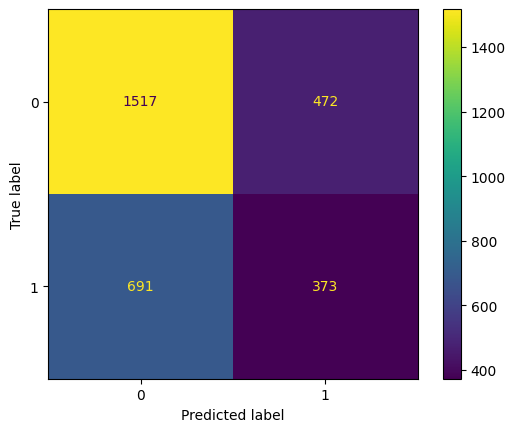

In [98]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, preds, labels=xgb1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb1.classes_)
disp.plot();

**Interpret:** The model is twice as likely to predict a false negative than it is to predict a false positive. Therefore, type II errors are more common. For our use case, this would be more desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, it's unlikely that this model would be deployed without further development to significantly improve its performance.

### Feature importance

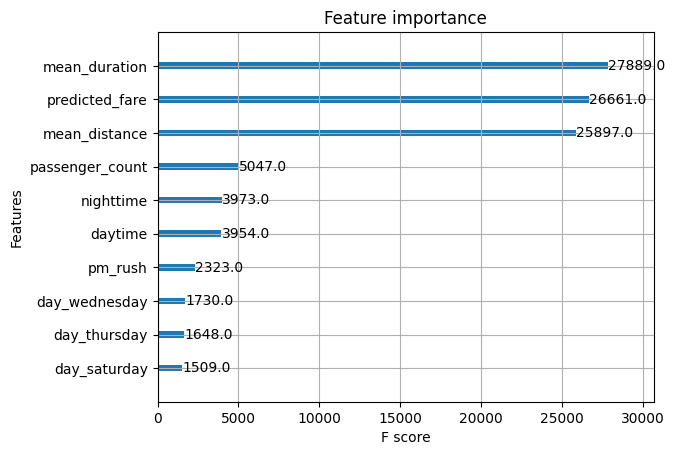

In [99]:
plot_importance(xgb1.best_estimator_, max_num_features=10);

## Conclusion

1. **Would you recommend using this model? Why or why not?**  
This is not a great model, but depending on how it's used it could still be useful. If the objective is only to help give taxi drivers a better idea of whether someone will leave a good tip, then it could be useful. It may be worthwhile to test it with a select group of taxi drivers to get feedback.

2. **What was your highest scoring model doing? Can you explain how it was making predictions?**   
Unfortunately, XGBoost is not the most transparent machine learning algorithm. We know that `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration.

3. **Are there new features that you can engineer that might improve model performance?**   
There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of $5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.


$$round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ $5}{fare\ amount}$$   

  <details>
    <summary><h5>HINT</h5></summary>
  $$ = \frac{5 - (fare\ mod\ 5)}{fare\ amount}$$  
  </details>


4. **What features would you want to have that would likely improve the performance of your model?**   
It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.


Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion. Even if you cannot use the model to make strong predictions, was the work done in vain? What insights can you report back to stakeholders?